In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def generate_data():
    size = 1000
    x = np.linspace(0, 1, size)
    y = -10*x + 5
    y += 15*np.logical_and(x > 0.75, x < 0.8).astype(float)
    return x, y

# 1. Inspect the data (0.5 points)

Using `matplotlib`, create a scatter plot of the data returned by `generate_data()`.
What is out of the ordinary about this line?

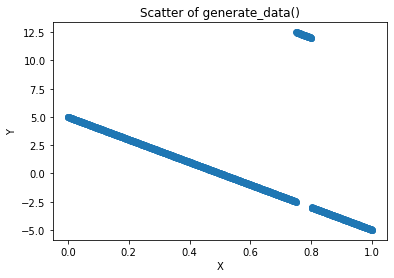

In [3]:
x,y = generate_data()
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter of generate_data()')
plt.show()

**Answer**: The above scatterplot demonstrates the very interesting property that datapoints where x is inbetween .75 and .80 are offset by a factor of 15. This piecewise function is not differentiable.

# 2. Implement linear regression (2 points)

Implement a basic linear regression model which is fit to the data from `generate_data` using gradient descent.
Your model should take the form `y = m*x + b`, where `y` is the output, `x` is the input, `m` is a weight parameter, and `b` is a bias parameter.
You must use only `numpy` and derive any derivatives yourself (i.e. no autograd from TensorFlow, MXNet, Pytorch, JAX etc!).
You should use a squared-error loss function.
You are welcome to use any technique you want to decide when to stop training.
Make sure you tune your optimization hyperparameters so that the model converges.
Print out or plot the loss over the course of training.

In [4]:
# Define the DataLoader Class

class DataLoader:
  """
  Implements a Data Loading Class for passing mini-batches to model after
  minor processing to ensure that matrix multiplication works. Assumes shuffle
  to be true. This is for mini-batch SGD handling.
  """
  def __init__(
      self, 
      inputs,
      labels,
      batch_size
  ):
    self.__len__ = len(labels)
    self.data = self.gen_tensor(inputs)
    self.labels = labels
    self.batch_size = batch_size
    self.called_idx = np.array([], dtype=int)
    self.prefetch = self.__get_idx__()
    
  
  def reshape_input(self, inputs):
    '''Reshapes input of dims >= 1 to a matrix of n x n_features'''
    n_examples = inputs.shape[0] #Assumes first dim is n_examples
    assert n_examples == self.__len__
    return inputs.reshape(n_examples, int(inputs.size/n_examples))
  
  def gen_tensor(self, inputs):
    '''Checks for iterable inputs and runs reshape above''' 
    try:
      iter(inputs)
    except TypeError:
      print("Inputs is not an iterable.")
    return self.reshape_input(inputs)
  
  def __get_idx__(self):
    '''Check that we have enough examples for another batch_size'''
    if self.__len__ - len(self.called_idx) < self.batch_size:
      # On epoch end reset the called indices
      self.called_idx = np.array([], dtype=int)
    remaining_idx = np.delete(np.arange(self.__len__), list(self.called_idx))
    idx = np.random.choice(remaining_idx, self.batch_size, replace=False)
    self.called_idx = np.append(self.called_idx, idx)
    return idx

  def _get_item_(self):
    '''Get a batch of the data when called with batch_size'''
    sampled_idx = self.__get_idx__()
    return (self.data[sampled_idx, :], self.labels[sampled_idx])

  def __len__(self):
    return self.__len__ // self.batch_size

In [5]:
# Define the LinearRegression Model Class

class LinearRegression:
    """
    Implements a Linear Regression Model Class for performing linear regression
    without the closed form solution. Randomly initializes weights and biases 
    before using mini-batch SGD to optimize weights
    """
    def __init__(
        self,
        input_dim
    ):
        self.params = {'weights': np.random.randn(input_dim),
                       'bias': 0}

    def forward(self, X):
        #Vectorized implementation of Forward Call w// broadcasting for bias
        return X @ self.params['weights'] + self.params['bias']

In [7]:
# Define the Gradient Descent Class

class SGD:
    """
    Implements gradient descent algorithm. Works with arbitrary models
    and loss functions (whose gradients are manually implemented).
    """
    def __init__(
        self,
        model, 
        learning_rate,
        grad_fxn
    ):
        self.eta = learning_rate
        self.grad = grad_fxn
        self.model = model

    def step(self, inputs, preds, labels):
        grads = self.grad(inputs, preds, labels)
        self.update_params(grads)

    def update_params(self, grads):
        params = self.model.params.keys()
        for i,p in enumerate(params):
            self.model.params[p] -= self.eta*grads[i]

In [32]:
# Define the Train_Iters Function
def train_iters(iterations, data_loader, model, lossfn, optimizer):
    running_loss = 0
    loss = []
    for i in tqdm(range(iterations)):
        x,y = data_loader._get_item_()
        preds = model.forward(x)
        running_loss += lossfn(preds, y)
        if  (i + 1) % 1000 == 0:
            loss += [running_loss/1000]
            running_loss = 0
        optimizer.step(x, preds, y)
    return loss

In [33]:
# Define the L2 Loss Function and Gradients

def l2_loss(preds, targets):
    return 1/2*np.sum(np.square(preds-targets))

def l2_grad(inputs, preds, targets):
    weights_grad = np.dot(inputs.T, preds-targets)/len(preds)
    bias_grad = np.dot(np.ones(len(targets)).T, preds-targets)/len(preds) 
    return weights_grad, bias_grad

In [76]:
dl = DataLoader(x, y , 64)
lr = LinearRegression(1)
sgd = SGD(lr, .01, l2_grad)

100%|██████████| 10000/10000 [00:01<00:00, 7573.01it/s]


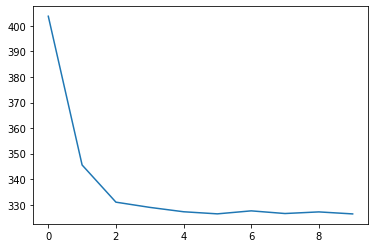

In [77]:
train_loss = train_iters(10000, dl, lr, l2_loss, sgd)
plt.plot(np.arange(len(train_loss)), train_loss)

# 3. Analyze the result (0.5 points)

Print out the values of `w` and `b` found by your model after training and compare them to the ground truth values (which can be found inside the code of the `generate_data` function).
Are they close?
Recreate the scatter plot you generated in question 1 and plot the model as a line on the same plot.
What went wrong?


In [78]:
lr.params

{'weights': array([-7.50894526]), 'bias': 4.5158849743398415}

In [79]:
def plot_lr_fit(weight, bias):
    x, y = generate_data()
    y_pred = weight*x + bias
    plt.scatter(x,y)
    plt.scatter(x,y_pred)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['Empirical Data', 'Slope: {}. Intercept: {}'.format(round(weight, 3), round(bias, 3))])
    plt.show()

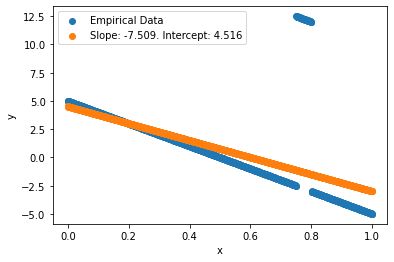

In [80]:
plot_lr_fit(lr.params['weights'][0], lr.params['bias'])

# 4. "Robust" linear regression (0.5 points)

Implement a linear regression model exactly like the one you created in question 2, except using a L1 loss (absolute difference) instead of a squared L2 loss (squared error).
You should be able to copy and paste your code from question 2 and only change a few lines.
Print out or plot the loss over the course of training.
What is different about the loss trajectory compared to the squared-error linear regression?

In [83]:
# Define the L1 Loss Function and Gradients

def l1_loss(preds, targets):
    return np.sum(np.abs(preds-targets))

def l1_grad(inputs, preds, targets):
    # Taken by piecewise derivative calculation
    weights_grad = np.dot(inputs.T, np.sign(preds-targets))/len(preds)
    bias_grad = np.dot(np.ones(len(targets)).T, np.sign(preds-targets))/len(preds)
    return weights_grad, bias_grad

In [91]:
dl = DataLoader(x, y , 64)
lr = LinearRegression(1)
sgd = SGD(lr, .01, l1_grad)

100%|██████████| 10000/10000 [00:01<00:00, 7583.80it/s]


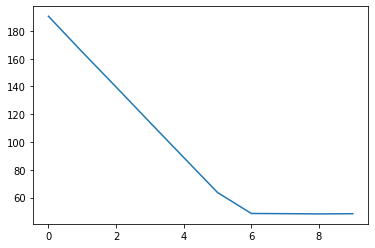

In [92]:
train_loss = train_iters(10000, dl, lr, l1_loss, sgd)
plt.plot(np.arange(len(train_loss)), train_loss)

**Answer**: The loss trajectory is less smooth and it has a visible kink in the curve. There is also a substantially fewer number of points where the trajectory of the curve changes. There are only two bends in this trajectory whereas in the L2 loss it changes at every point sampled.

# 5. Analyze the result (0.5 points)

Print out the new values of `w` and `b` found by your model after training.
Are they closer to the true values used in `generate_data`?
Plot the model as a line again.
Why do you think the behavior is different?

In [93]:
lr.params

{'weights': array([-9.99404795]), 'bias': 5.007812499999602}

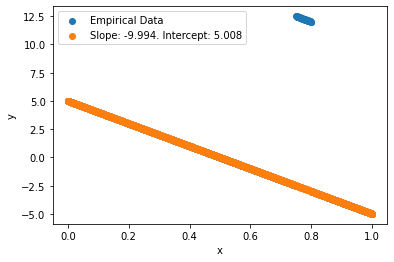

In [95]:
plot_lr_fit(lr.params['weights'][0], lr.params['bias'])

**Answer**: The behavior of the l1 loss is more robust to outliers in data due to the fact that the l2 loss function takes the  square of the difference of the predictions. Hence the resulting parameters are pushed towards values that yield a curve fit that gets pulled in the direction of the outliers. In the l1 loss, the square doesn't dominate so much so that the sheer number of points that are non-outliers are able to dictate the optimized parameters. In choosing which loss to use for regression, knowing whether there are outliers in the data has critical downstream effects. Conversely, if one has data that is tightly clustered, using the l2 loss will help the model converge far quicker and is preferable. 
